In [1]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import required packages
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [3]:
# Define parameters and dataset directory
batch_size = 32
img_height, img_width = 32, 32
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/data'  # Update path if needed

In [4]:
# Load the raw training and test datasets using image_dataset_from_directory
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Capture the class names for visualization later
class_names = raw_train_dataset.class_names

Found 3645 files belonging to 2 classes.
Using 2916 files for training.
Found 3645 files belonging to 2 classes.
Using 729 files for validation.


In [5]:
# Define a function to introduce heavy label noise (70%) and normalize the images.
def add_label_noise(x, y, noise_factor=0.7):
    # Create a noise tensor for each label in the batch
    noise = tf.random.uniform(shape=tf.shape(y), minval=0, maxval=1, dtype=tf.float32)
    # Generate random labels for the entire batch (matching the shape of y)
    random_labels = tf.random.uniform(shape=tf.shape(y), minval=0, maxval=2, dtype=tf.int64)
    # Replace with random label when noise < noise_factor, else keep the original label.
    noisy_y = tf.where(noise < noise_factor, random_labels, tf.cast(y, tf.int64))
    return x / 255.0, noisy_y

# Apply label noise to the training dataset; keep test dataset clean (only normalization)
train_dataset = raw_train_dataset.map(lambda x, y: add_label_noise(x, y, noise_factor=0.7))
test_dataset = raw_test_dataset.map(lambda x, y: (x / 255.0, y))


In [6]:
# Define a simplified CNN architecture with dropout to reduce capacity
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)  # For 2 classes (e.g., "Calculus" and "Gingivitis")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        18,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,570 (92.07 KB)

 Trainable params: 23,570 (92.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model (using 1 epoch here for demonstration; adjust to 80 epochs as needed)
history = model.fit(train_dataset, epochs=80, validation_data=test_dataset)

Epoch 1/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.5263 - loss: 0.7071 - val_accuracy: 0.6529 - val_loss: 0.6829
Epoch 2/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.5341 - loss: 0.6920 - val_accuracy: 0.6543 - val_loss: 0.6831
Epoch 3/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.5278 - loss: 0.6918 - val_accuracy: 0.6543 - val_loss: 0.6831
Epoch 4/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.5580 - loss: 0.6883 - val_accuracy: 0.6543 - val_loss: 0.6849
Epoch 5/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.5454 - loss: 0.6870 - val_accuracy: 0.6543 - val_loss: 0.6719
Epoch 6/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.5735 - loss: 0.6830 - val_accuracy: 0.5089 - val_loss: 0.6925
Epoch 7/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.5436 - loss: 0.6900 - val_accuracy: 0.6543 - val_loss: 0.6801
Epoch 8/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.5398 - loss: 0.6891 - val_accura

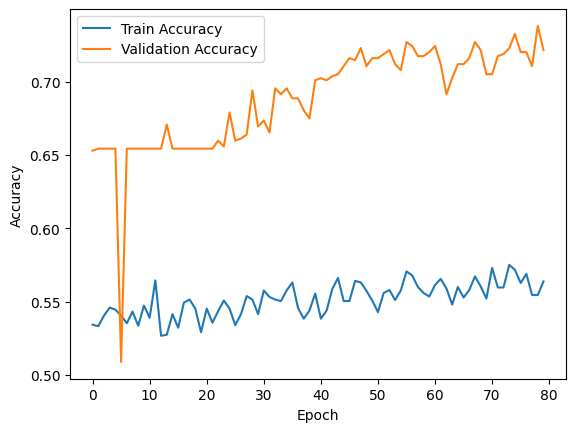

In [9]:
# Plot training and validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Evaluate the model using the built-in evaluate() method
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Calculate additional evaluation metrics: Accuracy, Macro-F1, Precision, Recall, AUROC.
all_labels = []
all_preds = []
all_probs = []

for images, labels in test_dataset:
    logits = model.predict(images)
    # Convert logits to probabilities using softmax
    probs = tf.nn.softmax(logits, axis=1).numpy()
    preds = np.argmax(probs, axis=1)

    all_labels.extend(labels.numpy())
    all_preds.extend(preds)
    all_probs.extend(probs)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

accuracy_val = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
precision_val = precision_score(all_labels, all_preds, average='macro')
recall_val = recall_score(all_labels, all_preds, average='macro')
# For AUROC, use the probability for the positive class (assumed index 1)
auroc_val = roc_auc_score(all_labels, all_probs[:, 1])

print(f"\nCalculated Test Accuracy: {accuracy_val:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"AUROC: {auroc_val:.4f}")

23/23 - 3s - 109ms/step - accuracy: 0.7215 - loss: 0.6407
Test Loss: 0.6406508088111877
Test Accuracy: 0.7215363383293152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
